Absolutely! The 3D bear model we created can be converted into a tensor format suitable for use with Physics-Informed Neural Networks (PINNs). Here's how you can do that:

1. First, we'll create a volumetric representation of the bear.
2. Then, we'll convert this into a tensor.
3. Finally, I'll explain how this could be used with a PINN.

Here's the code to create a volumetric representation and convert it to a tensor:


In [ ]:


import numpy as np
import torch

def in_sphere(x, y, z, cx, cy, cz, r):
    return ((x-cx)**2 + (y-cy)**2 + (z-cz)**2) <= r**2

# Create a volumetric grid
grid_size = 50
x = np.linspace(-2, 2, grid_size)
y = np.linspace(-2, 2, grid_size)
z = np.linspace(-2, 2, grid_size)
X, Y, Z = np.meshgrid(x, y, z)

# Create the bear volume
bear_volume = np.zeros((grid_size, grid_size, grid_size))

# Body
bear_volume |= in_sphere(X, Y, Z, 0, 0, 0, 1)

# Head
bear_volume |= in_sphere(X, Y, Z, 0, 1.2, 0.5, 0.6)

# Ears
bear_volume |= in_sphere(X, Y, Z, -0.3, 1.6, 0.7, 0.2)
bear_volume |= in_sphere(X, Y, Z, 0.3, 1.6, 0.7, 0.2)

# Snout
bear_volume |= in_sphere(X, Y, Z, 0, 1.5, 0.3, 0.3)

# Convert to PyTorch tensor
bear_tensor = torch.from_numpy(bear_volume.astype(np.float32))

print(f"Bear tensor shape: {bear_tensor.shape}")




This code does the following:

1. We define a function `in_sphere` to check if a point is inside a sphere.
2. We create a 3D grid and use our sphere function to create a volumetric representation of the bear.
3. We convert this numpy array to a PyTorch tensor.

Now, let's discuss how you might use this with a PINN:



1. Input: In a PINN for 3D reconstruction, your input would typically be the coordinates (x, y, z). You can create this from your grid:

```python
coords = torch.stack(torch.meshgrid(torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(z)), dim=-1)
coords = coords.view(-1, 3)
```



2. Output: Your bear_tensor would be the target output, representing the occupancy (1 inside the bear, 0 outside) at each point. You'd reshape it to match the coords:


```python
target = bear_tensor.view(-1, 1)
```



3. PINN Model: You'd define a neural network that takes (x, y, z) as input and predicts the occupancy. Here's a simple example:

```python
class BearPINN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)
```

4. Training: You'd train this network to predict the occupancy, possibly incorporating physical constraints (like smoothness) in the loss function.

5. Inference: After training, you can use the model to predict occupancy at any point in 3D space, allowing you to reconstruct the bear at arbitrary resolutions.

This approach turns the 3D reconstruction problem into a supervised learning task with additional physics-informed constraints. The PINN learns an implicit representation of the 3D shape, which can be queried at any point in space.

Would you like me to elaborate on any part of this process or provide an example of how you might incorporate physical constraints into the PINN?

/Users/jiangyicheng/Desktop/JYC noval/ML4_3D/ML4_3D/.venv/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch [10/100], Loss: 0.6039
Epoch [20/100], Loss: 0.5525
Epoch [30/100], Loss: 0.5150
Epoch [40/100], Loss: 0.4785
Epoch [50/100], Loss: 0.4493
Epoch [60/100], Loss: 0.4272
Epoch [70/100], Loss: 0.4111
Epoch [80/100], Loss: 0.3998
Epoch [90/100], Loss: 0.3920
Epoch [100/100], Loss: 0.3865


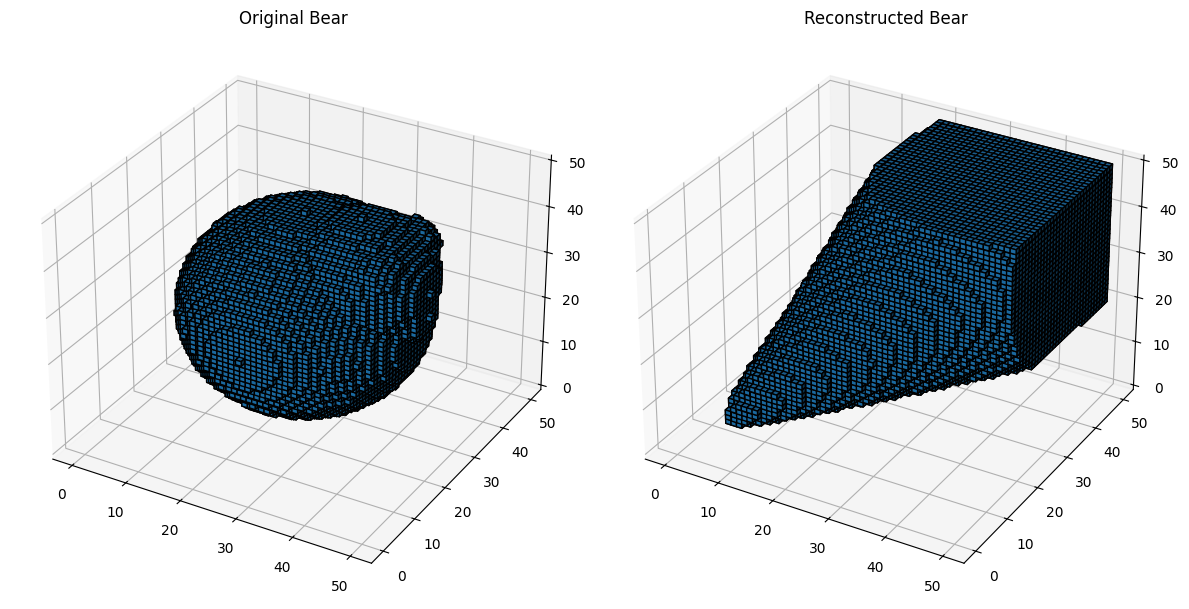

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to create a sphere
def create_sphere(size, radius, center):
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    z = np.linspace(0, size-1, size)
    X, Y, Z = np.meshgrid(x, y, z)
    
    distance = np.sqrt((X - center[0])**2 + (Y - center[1])**2 + (Z - center[2])**2)
    sphere = (distance <= radius).astype(float)
    return sphere

# Create the bear volume
grid_size = 50
bear_volume = np.zeros((grid_size, grid_size, grid_size))

# Body
bear_volume += create_sphere(grid_size, 20, (25, 25, 25))
# Head
bear_volume += create_sphere(grid_size, 12, (25, 35, 35))
# Ears
bear_volume += create_sphere(grid_size, 5, (20, 40, 40))
bear_volume += create_sphere(grid_size, 5, (30, 40, 40))
# Snout
bear_volume += create_sphere(grid_size, 7, (25, 40, 30))

# Normalize to 0-1 range
bear_volume = np.clip(bear_volume, 0, 1)

# Convert to PyTorch tensor
bear_tensor = torch.from_numpy(bear_volume.astype(np.float32))

# Create input coordinates
x = torch.linspace(0, grid_size-1, grid_size)
y = torch.linspace(0, grid_size-1, grid_size)
z = torch.linspace(0, grid_size-1, grid_size)
coords = torch.stack(torch.meshgrid(x, y, z), dim=-1)
coords = coords.view(-1, 3)

# Create target tensor
target = bear_tensor.view(-1, 1)

# Define the PINN model
class BearPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model, loss function, and optimizer
model = BearPINN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(coords)
    loss = criterion(outputs, target)
    
    # Add a physics-informed constraint (smoothness)
    coords.requires_grad_(True)
    outputs = model(coords)
    grad_outputs = torch.ones_like(outputs)
    gradients = torch.autograd.grad(outputs, coords, grad_outputs=grad_outputs, create_graph=True)[0]
    smoothness_loss = torch.mean(torch.sum(gradients**2, dim=1))
    
    total_loss = loss + 0.01 * smoothness_loss
    
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

# Visualize the results
with torch.no_grad():
    predicted_volume = model(coords).view(grid_size, grid_size, grid_size).numpy()

# Create a 3D plot of the original and reconstructed bear
fig = plt.figure(figsize=(12, 6))

# Original bear
ax1 = fig.add_subplot(121, projection='3d')
ax1.voxels(bear_volume > 0.5, edgecolor='k')
ax1.set_title('Original Bear')

# Reconstructed bear
ax2 = fig.add_subplot(122, projection='3d')
ax2.voxels(predicted_volume > 0.5, edgecolor='k')
ax2.set_title('Reconstructed Bear')

plt.tight_layout()
plt.show()